In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stat
from tqdm import tqdm
import seaborn as sns
from scipy.special import gamma
np.random.seed(10)

# Exercice 1 

### Question 2

On commence par choisir les paramètres fixes dans le modèle.

In [2]:
N = 5
K = 100
t_ij = np.array([range(K) for i in range(N)])

p0 = 10
sigma_t0 = 1
sigma_v0 = 2

mean_t0 = 0
s_t0 = 1

mean_v0 = 2
s_v0 = 1

v_xi = 0.1
m_xi = 1
v_tau = 0.2
m_tau = 3
v = 0.3
m = 1


In [3]:
def d(t,p0,t0,v0):
    return p0 + v0*(t - t0)

On peut ensuite simuler les paramètres que l'on va chercher à estimer ainsi que les données du problème.

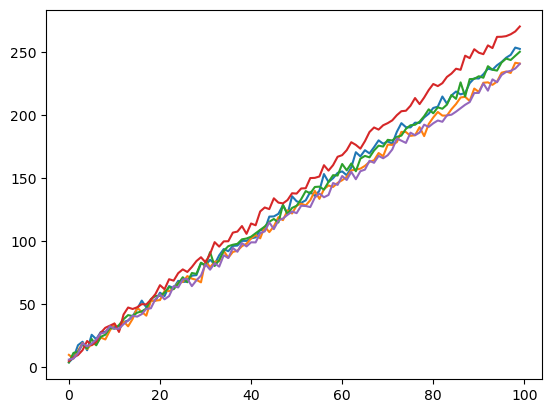

In [4]:
sigma_xi_vrai = stat.invwishart.rvs(df=m_xi,scale=v_xi)
sigma_tau_vrai = stat.invwishart.rvs(df=m_tau,scale=v_tau)
sigma_vrai = stat.invwishart.rvs(df=m,scale=v)

t0_bar_vrai = stat.norm.rvs(loc=mean_t0, scale=s_t0**2)
v0_bar_vrai = stat.norm.rvs(loc=mean_v0, scale=s_v0**2)

t0_vrai = stat.norm.rvs(loc=t0_bar_vrai, scale=sigma_t0**2)
v0_vrai = stat.norm.rvs(loc=v0_bar_vrai, scale=sigma_v0**2)

tau_vrai = stat.norm.rvs(loc=0, scale=sigma_tau_vrai, size=N)
xi_vrai = stat.norm.rvs(loc=0, scale=sigma_xi_vrai, size=N)
alpha_vrai = np.exp(xi_vrai)

eps_vrai = stat.norm.rvs(loc=0, scale=sigma_vrai, size=(N,K))

y = np.zeros((N,K))
for i in range(N):
    for j in range(K):
        y[i,j] = d(alpha_vrai[i]*(t_ij[i,j]-t0_vrai-tau_vrai[i])+t0_vrai,p0,t0_vrai,v0_vrai) + eps_vrai[i,j]

    plt.plot(y[i])

### Question 3

On implémente l'algorithme Metropolis-Hastings afin de tirer la varibale $z$ depuis la distribution $(z\mid y,\theta)$.

In [5]:
def log_posteriori(z,N,t0_bar,v0_bar,sigma_xi,sigma_tau,sigma,sigma_t0,sigma_v0,t_ij,y):
    #z = (t0,v0,xi_1,tau_1,xi_2,tau_2...)
    #xi_i sont aux positions paires, tau_i aux positions impaires
    t0, v0 = z[0:2]
    xi = z[2::2].reshape(-1, 1)  
    tau = z[3::2].reshape(-1, 1)

    #log q(y | z, theta)
    q_y = -np.sum((y - d(np.exp(xi)*(t_ij-t0-tau)+t0,p0,t0,v0))**2)/(2*sigma**2)

    #log q(z | theta)
    q_xi = -0.5*np.sum((xi/sigma_xi)**2)
    q_tau = -0.5*np.sum((tau/sigma_tau)**2)
    q_t0 = -0.5*(((t0-t0_bar)/sigma_t0)**2)
    q_v0 = -0.5*(((v0-v0_bar)/sigma_v0)**2)

    return q_y + q_xi + q_tau + q_t0 + q_v0

def alpha(z_k,z_star,N,t0_bar,v0_bar,sigma_xi,sigma_tau,sigma,sigma_t0, sigma_v0,t_ij,y):
    num = log_posteriori(z_star,N,t0_bar,v0_bar,sigma_xi,sigma_tau,sigma,sigma_t0, sigma_v0,t_ij,y)
    denom = log_posteriori(z_k,N,t0_bar,v0_bar,sigma_xi,sigma_tau,sigma,sigma_t0, sigma_v0,t_ij,y)
    return min(0,num - denom)

In [6]:
def SRWHM(maxIter,N,z_init,Sigma_prop,t0_bar,v0_bar,sigma_xi,sigma_tau,sigma,sigma_t0, sigma_v0,t_ij,y):
    
    z = np.zeros((maxIter+1,2*N+2))
    z[0] = z_init
    
    for k in range(maxIter):
        #Proposal 
        z_star = stat.multivariate_normal.rvs(mean=z[k],cov=Sigma_prop)
        
        #Acceptance-Rejection
        U = stat.uniform.rvs()
        if np.log(U) <= alpha(z[k],z_star,N,t0_bar,v0_bar,sigma_xi,sigma_tau,sigma,sigma_t0, sigma_v0,t_ij,y):
            z[k+1] = np.copy(z_star)
        else:
            z[k+1] = np.copy(z[k])
    return z

On test alors notre échantillonneur.

In [7]:
z_init = 2*(np.random.random(2*N+2)-0.5)
maxIter = 100000

Sigma_prop = 1e-5*np.eye(2*N+2)

In [8]:
z = SRWHM(maxIter,N,z_init,Sigma_prop,t0_bar_vrai,v0_bar_vrai,sigma_xi_vrai,
          sigma_tau_vrai,sigma_vrai,sigma_t0, sigma_v0,t_ij,y)

#### Echantillons pour $t_0$. 

On regarde ce que donne les échantillons de $t_0$. 

On voit que globalement, ces echantillons sont bien centrés autour de $\overline{t_0}$ mais qu'ils ne suivent pas vraiment la loi qu'ils devraient suivre, c'est-à-dire une $\mathcal{N}(\overline{t_0},\sigma_{t_0})$.

J'ai cherché l'erreur pendant longtemps, mais jamais trouvé pourquoi j'obtenais de si mauvais resultats...

Text(0.5, 1.0, 'Les echantillons $t_0$')

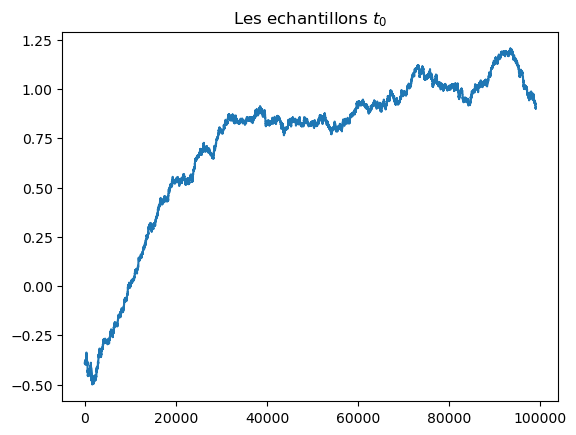

In [9]:
plt.plot(z[1000:,0])
plt.title("Les echantillons $t_0$")

Text(0.5, 1.0, "Compraison entre la densité empirique des échantillons de $t_0$ et \nla vraie densité qu'ils devraient suivre")

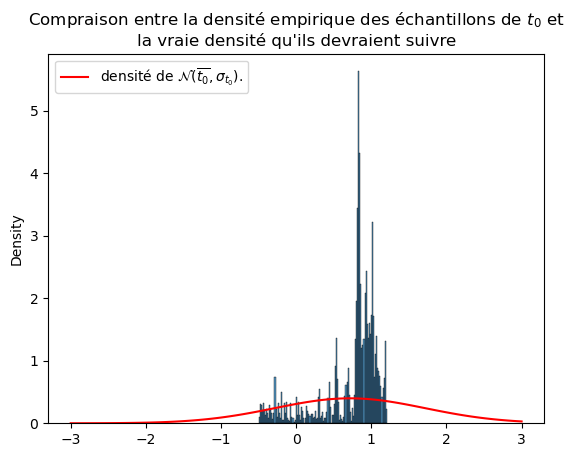

In [10]:
x = np.linspace(-3,3,100)
sns.histplot(z[1000:,0],stat="density")
plt.plot(x,stat.norm.pdf(x,loc=t0_bar_vrai,scale=sigma_t0),color='red',label="densité de $\mathcal{N}(\overline{t_0},\sigma_{t_0})$.")
plt.legend()
plt.title("Compraison entre la densité empirique des échantillons de $t_0$ et \nla vraie densité qu\'ils devraient suivre")

#### Echantillons pour $v_0$. 

Les échantillons pour $v_0$ semblent également être centrés autour de $\overline{v_0}$ mais ne semblent pas non plus suivrent la loi gaussienne $\mathcal{N}(\overline{v_0},\sigma_{v_0})$.

Text(0.5, 1.0, "Compraison entre la densité empirique des échantillons de $v_0$ et \nla vraie densité qu'ils devraient suivre")

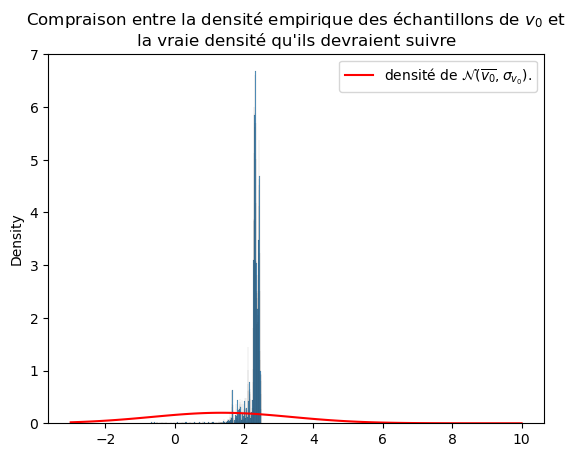

In [11]:
x = np.linspace(-3,10,100)
sns.histplot(z[100:,1],stat="density")
plt.plot(x,stat.norm.pdf(x,loc=v0_bar_vrai,scale=sigma_v0),color='red',label="densité de $\mathcal{N}(\overline{v_0},\sigma_{v_0})$.")
plt.legend()
plt.title("Compraison entre la densité empirique des échantillons de $v_0$ et \nla vraie densité qu\'ils devraient suivre")

#### Echantillons de $\xi_1$ et $\tau_1$

Pour une fois, on a un résultat qui semble être cohérent avec la théorie ! Après des heures à essayer d'y arriver je suis content !

Text(0.5, 1.0, "Compraison entre la densité empirique des échantillons de $\\xi_i$ et \nla vraie densité qu'ils devraient suivre")

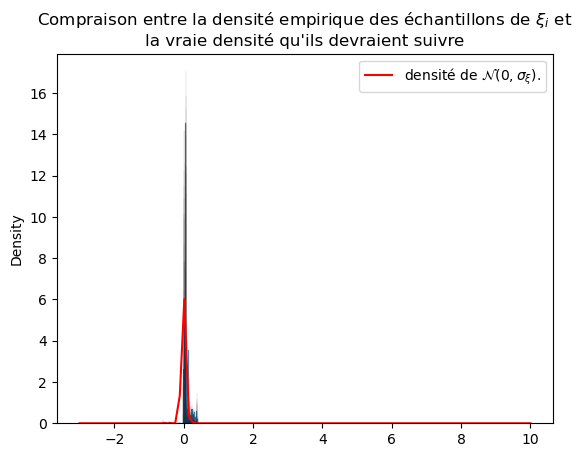

In [12]:
sns.histplot(z[1000:,2],stat="density")
plt.plot(x,stat.norm.pdf(x,loc=0,scale=sigma_xi_vrai),color='red',label="densité de $\mathcal{N}(0,\sigma_{\\xi})$.")
plt.legend()
plt.title("Compraison entre la densité empirique des échantillons de $\\xi_i$ et \nla vraie densité qu\'ils devraient suivre")

Text(0.5, 1.0, "Compraison entre la densité empirique des échantillons de $\\tau_i$ et \nla vraie densité qu'ils devraient suivre")

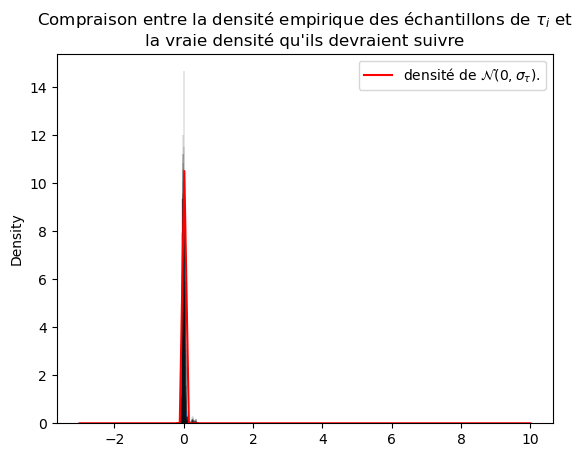

In [13]:
sns.histplot(z[1000:,3],stat="density")
plt.plot(x,stat.norm.pdf(x,loc=0,scale=sigma_tau_vrai),color='red',label="densité de $\mathcal{N}(0,\sigma_{\\tau})$.")
plt.legend()

plt.title("Compraison entre la densité empirique des échantillons de $\\tau_i$ et \nla vraie densité qu\'ils devraient suivre")

### Question 4

On implémente ensuite l'algorithme MCMC-SAEM afin d'estimer les paramètres $\theta$ du modèle.

In [14]:
def eps(k,Nb,alpha):
    if k <= Nb:
        return 1
    else:
        return np.power((k - Nb),-alpha)
    
def S_function(y,z):
    t0, v0 = z[0:2]
    xi = z[2::2].reshape(-1, 1)  
    tau = z[3::2].reshape(-1, 1)
    S1 = np.sum((y - d(np.exp(xi)*(t_ij-t0-tau)+t0,p0,t0,v0))**2)/(N*K)
    S2 = t0
    S3 = v0
    S4 = np.sum(tau**2)/N
    S5 = np.sum(xi**2)/N
    return np.array([S1,S2,S3,S4,S5])

def next_theta(S):
    next_t0_bar = (S[1]/(sigma_t0**2) + mean_t0/(s_t0**2))/(1/sigma_t0**2 + 1/s_t0**2)
    next_v0_bar = (S[2]/(sigma_v0**2) + mean_v0/(s_v0**2))/(1/sigma_v0**2 + 1/s_v0**2)
    
    next_sigma_xi = np.sqrt((S[4]*N + v_xi**2)/(N + m_xi + 2))
    next_sigma_tau = np.sqrt((S[3]*N + v_tau**2)/(N + m_tau + 2))
    next_sigma = np.sqrt((S[0]*N*K + v**2)/(N*K + m + 2))
    return next_t0_bar,next_v0_bar,next_sigma_xi,next_sigma_tau,next_sigma

In [15]:
def MCMC_SAEM(y,theta_init,maxIter,Nb,alpha,N,t_ij,sigma_t0, sigma_v0):
    z = np.zeros((maxIter + 1,2*N+2))
    S = np.zeros((maxIter + 1,5))
    t0_bar = theta_init[0]
    v0_bar = theta_init[1]
    sigma_xi = theta_init[2]
    sigma_tau = theta_init[3]
    sigma = theta_init[4]
    for k in tqdm(range(maxIter)):
        Sigma_prop = 1e-5*np.eye(2*N+2)
        z_sample = SRWHM(1000,N,z[k],Sigma_prop,t0_bar,
                         v0_bar,sigma_xi,sigma_tau,sigma,sigma_t0, sigma_v0,t_ij,y)
        z[k+1] = z_sample[-1]
        S[k+1] = S[k] + eps(k,Nb,alpha)*(S_function(y,z[k+1]) - S[k])
        t0_bar,v0_bar,sigma_xi,sigma_tau,sigma = next_theta(S[k+1])
        
    return t0_bar,v0_bar,sigma_xi,sigma_tau,sigma

On test alors notre algorithme.

In [16]:
theta_init = np.random.random(5)
maxIter = 1000
Nb = 20
a = 0.5
(t0_bar,v0_bar,sigma_xi,sigma_tau,sigma) = MCMC_SAEM(y,theta_init,maxIter,Nb,a,N,t_ij,sigma_t0, sigma_v0)

100%|███████████████████████████████████████| 1000/1000 [01:56<00:00,  8.60it/s]


On compare les paramètres estimés avec les vrais paramètres en comparant les densités.

Text(0.5, 0.98, 'Comparaison entre les densités théoriques et les densités estimées grâce à MCMC_SAEM')

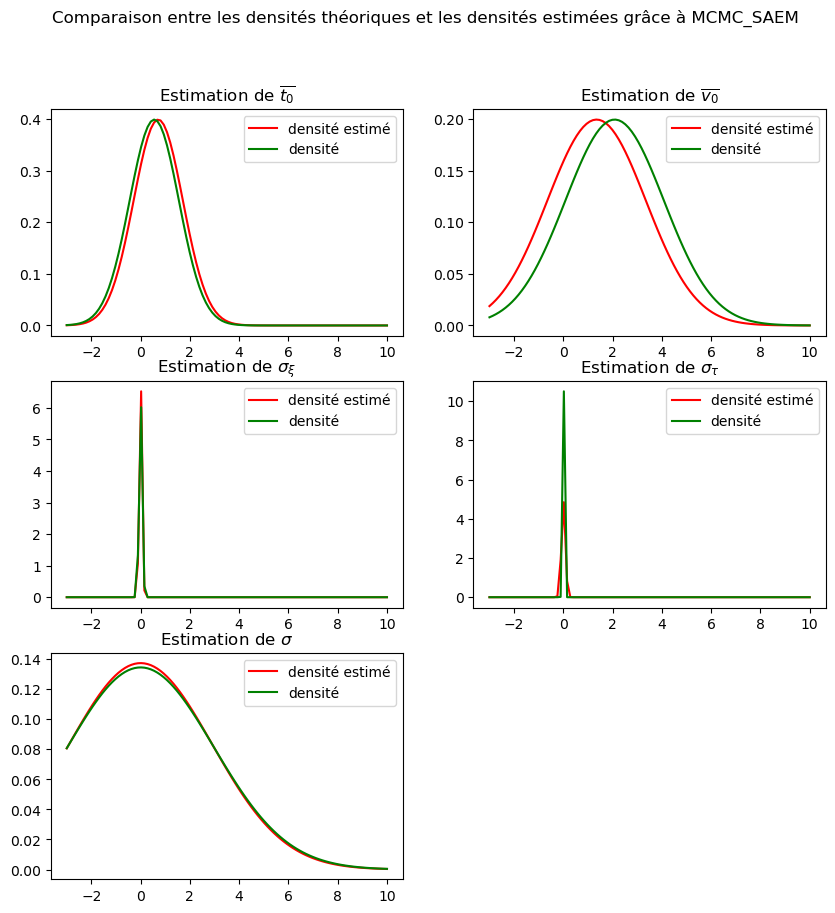

In [17]:
plt.figure(figsize = (10,10))
plt.subplot(3,2,1)
plt.plot(x,stat.norm.pdf(x,loc=t0_bar_vrai,scale=sigma_t0),color='red',label="densité estimé")
plt.plot(x,stat.norm.pdf(x,loc=t0_bar,scale=sigma_t0),color='green',label="densité")
plt.legend()
plt.title("Estimation de $\\overline{t_0}$")

plt.subplot(3,2,2)
plt.plot(x,stat.norm.pdf(x,loc=v0_bar_vrai,scale=sigma_v0),color='red',label="densité estimé")
plt.plot(x,stat.norm.pdf(x,loc=v0_bar,scale=sigma_v0),color='green',label="densité")
plt.legend()
plt.title("Estimation de $\\overline{v_0}$")

plt.subplot(3,2,3)
plt.plot(x,stat.norm.pdf(x,loc=0,scale=sigma_xi),color='red',label="densité estimé")
plt.plot(x,stat.norm.pdf(x,loc=0,scale=sigma_xi_vrai),color='green',label="densité")
plt.legend()
plt.title("Estimation de $\\sigma_{\\xi}$")

plt.subplot(3,2,4)
plt.plot(x,stat.norm.pdf(x,loc=0,scale=sigma_tau),color='red',label="densité estimé")
plt.plot(x,stat.norm.pdf(x,loc=0,scale=sigma_tau_vrai),color='green',label="densité")
plt.legend()
plt.title("Estimation de $\\sigma_{\\tau}$")

plt.subplot(3,2,5)
plt.plot(x,stat.norm.pdf(x,loc=0,scale=sigma),color='red',label="densité estimé")
plt.plot(x,stat.norm.pdf(x,loc=0,scale=sigma_vrai),color='green',label="densité")
plt.legend()
plt.title("Estimation de $\\sigma$")

plt.suptitle("Comparaison entre les densités théoriques et les densités estimées grâce à MCMC_SAEM")

On constate que les paramètres $\theta$ estimés sont très bon ! En effet, les densités estimées sont très proches des densités théoriques ! L'algorithme MCMC_SAEM fonctionne donc ! 

### Question 5

On implémente l'algorithme Metropolis-Hastings within Gibbs sampler afin de tirer des échantillons de la variable $z_i = (\xi_i,\tau_i)$.

In [18]:
def MHwG_zi(y,N,t_ij,sigma_tau,sigma_xi,xi_init,tau_init,sigma_prop,t0,p0,v0,sigma):
    tau = np.zeros(N)
    xi = np.zeros(N)
    
    for l in range(N):
        yl = y[l, :]
        
        ###### Pour tau ######
        
        #Proposal 
        tau_l_proposal = stat.norm.rvs(loc=tau_init[l],scale=sigma_prop**2)
        
        
        #Acceptance-Rejection
        q_y_current = -np.sum((yl - d(np.exp(xi_init[l])*(t_ij-t0-tau_init[l])+t0,p0,t0,v0))**2)/(2*sigma**2)
        q_tau_current = -0.5*(tau_init[l]/sigma_tau)**2
        
        q_y_proposal = -np.sum((yl - d(np.exp(xi_init[l])*(t_ij-t0-tau_l_proposal)+t0,p0,t0,v0))**2)/(2*sigma**2)
        q_tau_proposal = -0.5*(tau_l_proposal/sigma_tau)**2
        
        log_alpha_tau = min(0,q_y_proposal + q_tau_proposal - q_y_current - q_tau_current)
        U = stat.uniform.rvs()
        if np.log(U) <= log_alpha_tau:
            tau[l] = tau_l_proposal
        else:
            tau[l] = tau_init[l]
            
        ###### Pour xi ######
        
         #Proposal 
        xi_l_proposal = stat.norm.rvs(loc=xi_init[l],scale=sigma_prop**2)
        
        
        #Acceptance-Rejection
        q_y_current = -np.sum((yl - d(np.exp(xi_init[l])*(t_ij-t0-tau[l])+t0,p0,t0,v0))**2)/(2*sigma**2)
        q_xi_current = -0.5*(xi_init[l]/sigma_xi)**2
        
        q_y_proposal = -np.sum((yl - d(np.exp(xi_l_proposal)*(t_ij-t0-tau[l])+t0,p0,t0,v0))**2)/(2*sigma**2)
        q_xi_proposal = -0.5*(xi_l_proposal/sigma_xi)**2
        
        log_alpha_xi = min(0,q_y_proposal + q_xi_proposal - q_y_current - q_xi_current)
        U = stat.uniform.rvs()
        if np.log(U) <= log_alpha_xi:
            xi[l] = xi_l_proposal
        else:
            xi[l] = xi_init[l]
        

    return xi, tau 
        

In [19]:
sigma_prop = 1
nb_iter = 10000

tau = np.zeros((nb_iter+1,N))
xi = np.zeros((nb_iter+1,N))

tau[0] = np.random.random(N)
xi[0] = np.random.random(N)

for i in tqdm(range(nb_iter)):
    xi[i+1],tau[i+1] = MHwG_zi(y,N,t_ij,sigma_tau_vrai,sigma_xi_vrai,xi[i],tau[i],sigma_prop,t0_vrai,p0,v0_vrai,sigma_vrai)

100%|███████████████████████████████████| 10000/10000 [00:07<00:00, 1267.51it/s]


On test alors notre algorithme en comparant les densité des $\xi_i$ et des $\tau_i$ tirés grâce à MHwG avec les densités théoriques $\mathcal{N}(0,\sigma_{\\xi})$ et $\mathcal{N}(0,\sigma_{\\tau})$.

Text(0.5, 1.0, "Compraison entre la densité empirique des échantillons de $\\xi_i$ et \nla vraie densité qu'ils devraient suivre")

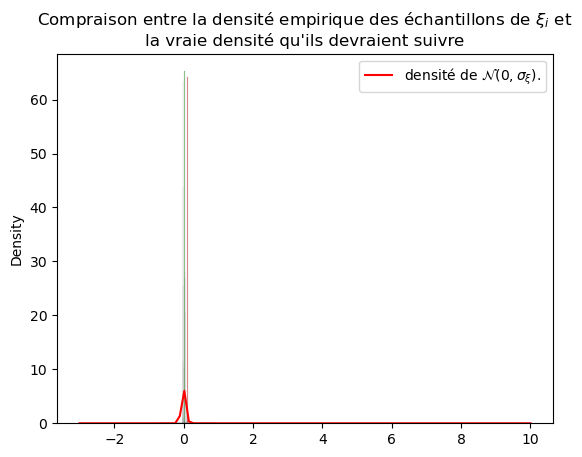

In [20]:
sns.histplot(xi,stat="density")
plt.plot(x,stat.norm.pdf(x,loc=0,scale=sigma_xi_vrai),color='red',label="densité de $\mathcal{N}(0,\sigma_{\\xi})$.")
plt.legend()
plt.title("Compraison entre la densité empirique des échantillons de $\\xi_i$ et \nla vraie densité qu\'ils devraient suivre")

Text(0.5, 1.0, "Compraison entre la densité empirique des échantillons de $\\tau_i$ et \nla vraie densité qu'ils devraient suivre")

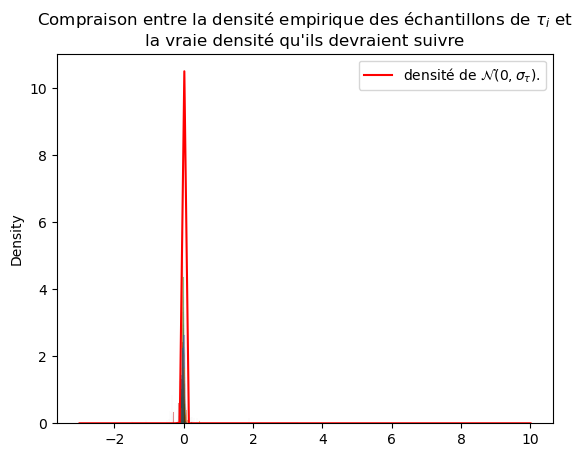

In [21]:
sns.histplot(tau,stat="density")
plt.plot(x,stat.norm.pdf(x,loc=0,scale=sigma_tau_vrai),color='red',label="densité de $\mathcal{N}(0,\sigma_{\\tau})$.")
plt.legend()
plt.title("Compraison entre la densité empirique des échantillons de $\\tau_i$ et \nla vraie densité qu\'ils devraient suivre")

On observe que les échantillons tirés sont bien centrés autour des bonnes valeurs, c'est à dire $0$. On voit que les échantillons de $\tau_i$ sont plutôt bons, alors que ceux de $\xi_i$ sont trop concentrés autour de $0$.  

### Question 6

On implémente l'algorithme Metropolis-Hastings within Gibbs sampler afin de tirer des échantillons de la variable $z_{pop} = (t_0,v_0)$.

In [22]:
def MHwG_zpop(y,N,K,t_ij,t0_init,v0_init,sigma_prop,p0,xi,tau,t0_bar,v0_bar,sigma_t0,sigma_v0,sigma):

    dist_current = np.zeros((N,K))
    dist_proposal = np.zeros((N,K))

    ###### Pour t0 ######
    t0_proposal = stat.norm.rvs(loc=t0_init,scale = sigma_prop**2)
    for j in range(K) : 
        dist_current[:,j] = d(np.exp(xi)*(t_ij[:,j] - t0_init - tau) + t0_init , p0, v0_init, t0_init)

        dist_proposal[:,j]= d(np.exp(xi)*(t_ij[:,j] - t0_proposal - tau) + t0_proposal , p0, v0_init, t0_proposal)
    
    q_y_current = -np.sum((y - dist_current)**2)/(2*sigma**2)
    q_t0_current = -0.5*(((t0_init-t0_bar)/sigma_t0)**2)
    
    q_y_proposal = -np.sum((y - dist_proposal)**2)/(2*sigma**2)
    q_t0_proposal = -0.5*(((t0_proposal-t0_bar)/sigma_t0)**2)
    
    log_alpha_t0 = min(0,q_y_proposal + q_t0_proposal - q_y_current - q_t0_current)
    U = stat.uniform.rvs()
    if np.log(U) <= log_alpha_t0:
        t0 = t0_proposal
    else:
        t0 = t0_init
    
    ###### Pour v0 ######
    
    dist_current = np.zeros((N,K))
    dist_proposal = np.zeros((N,K))
                             
    v0_proposal = stat.norm.rvs(loc=v0_init,scale = sigma_prop**2)
    for j in range(K) : 
        dist_current[:,j] = d(np.exp(xi)*(t_ij[:,j] - t0 - tau) + t0 , p0, v0_init, t0)

        dist_proposal[:,j]= d(np.exp(xi)*(t_ij[:,j] - t0 - tau ) + t0 , p0, v0_proposal, t0)
        
    q_y_current = -np.sum((y - dist_current)**2)/(2*sigma**2)
    q_v0_current = -0.5*(((v0_init-v0_bar)/sigma_v0)**2)
    
    q_y_proposal = -np.sum((y - dist_proposal)**2)/(2*sigma**2)
    q_v0_proposal= -0.5*(((v0_proposal-v0_bar)/sigma_v0)**2)
    
    log_alpha_v0 = min(0,q_y_proposal + q_v0_proposal - q_y_current - q_v0_current)
    U = stat.uniform.rvs()
    if np.log(U) <= log_alpha_v0:
        v0 = v0_proposal
    else:
        v0 = v0_init
        
    return t0,v0
    

On test alors notre algorithme en comparant les densité des $t_0$ et des $v_0$ tirés grâce à MHwG avec les densités théoriques $\mathcal{N}(\overline{t_0},\sigma_{t_0})$ et $\mathcal{N}(\overline{v_0},\sigma_{v_0})$.

In [23]:
sigma_prop = 1
nb_iter = 10000

t0 = np.zeros(nb_iter+1)
v0 = np.zeros(nb_iter+1)

t0[0] = 2*(np.random.random(1)-0.5)
v0[0] = 2*(np.random.random(1)-0.5)

for i in tqdm(range(nb_iter)):
    t0[i+1],v0[i+1] = MHwG_zpop(y,N,K,t_ij,t0[i],v0[i],sigma_prop,p0,xi_vrai,tau_vrai,t0_bar_vrai,v0_bar_vrai,sigma_t0,sigma_v0,sigma_vrai)

100%|████████████████████████████████████| 10000/10000 [00:27<00:00, 360.39it/s]


Text(0.5, 1.0, "Compraison entre la densité empirique des échantillons de $v_0$ et \nla vraie densité qu'ils devraient suivre")

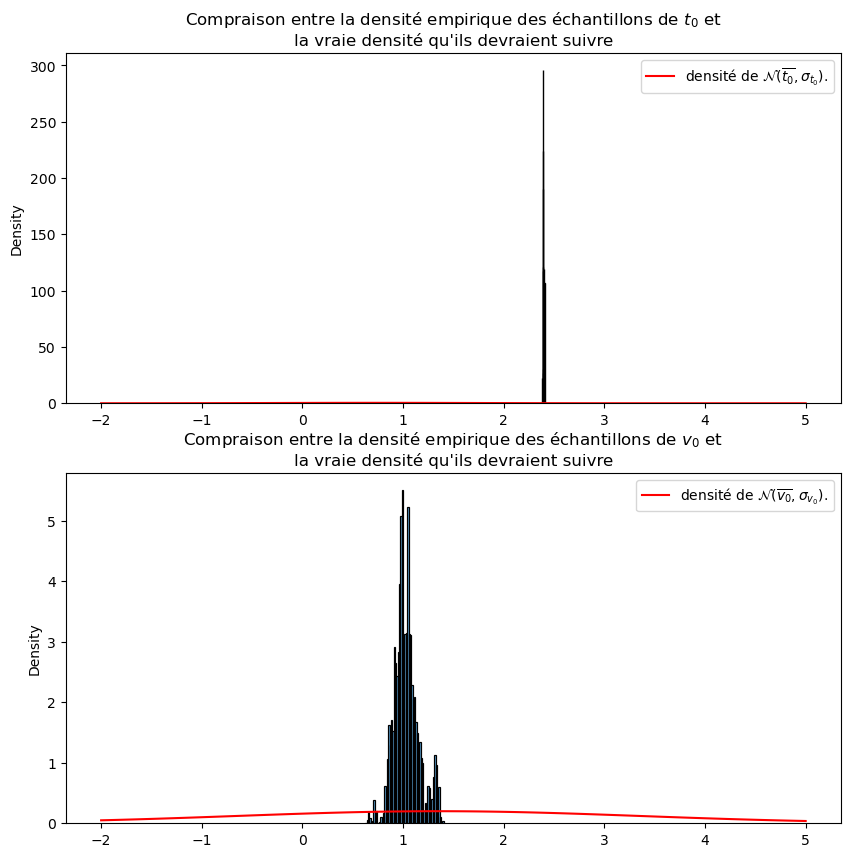

In [24]:
x = np.linspace(-2,5,100)
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
sns.histplot(t0[1000:],stat="density")
plt.plot(x,stat.norm.pdf(x,loc=t0_bar_vrai,scale=sigma_t0),color='red',label="densité de $\mathcal{N}(\overline{t_0},\sigma_{t_0})$.")
plt.legend()
plt.title("Compraison entre la densité empirique des échantillons de $t_0$ et \nla vraie densité qu\'ils devraient suivre")

plt.subplot(2,1,2)
sns.histplot(v0[1000:],stat="density")
plt.plot(x,stat.norm.pdf(x,loc=v0_bar_vrai,scale=sigma_v0),color='red',label="densité de $\mathcal{N}(\overline{v_0},\sigma_{v_0})$.")
plt.legend()
plt.title("Compraison entre la densité empirique des échantillons de $v_0$ et \nla vraie densité qu\'ils devraient suivre")

Les échantillons tirés ne sont pas de très bonne qualité. On observe que les échantillons de $v_0$ sont meilleurs que ceux de $t_0$n étant donné qu'ils ressemblent plus à une gaussienne et sont centrés autour de la bonne valeur $\overline{v_0}$. Pour ce qui est de $t_0$, je ne sais pas ce qui est le problème. 

### Question 7

Enfin, on implémente l'algorithme HMwG_SAEM afin d'estimer les paramètres $\theta$ du modèle grâce aux échantillonneurs de Hasting-Metropolis within Gibbs sampler. 

In [25]:
def HMwG_SAEM(y,theta_init,maxIter,Nb,alpha,N,t_ij,sigma_t0, sigma_v0,sigma_prop):
    z = np.zeros((maxIter + 1,2*N+2))
    S = np.zeros((maxIter + 1,5))
    t0_bar = theta_init[0]
    v0_bar = theta_init[1]
    sigma_xi = theta_init[2]
    sigma_tau = theta_init[3]
    sigma = theta_init[4]
    nb_iter = 100
    for k in tqdm(range(maxIter)):
        #Sample of z_i and z_pop
        
        tau = np.zeros((nb_iter+1,N))
        xi = np.zeros((nb_iter+1,N))
        t0 = np.zeros(nb_iter+1)
        v0 = np.zeros(nb_iter+1)
        
        tau[0] = 2*(np.random.random(N)-1)
        xi[0] = 2*(np.random.random(N)-1)
        t0[0] = 2*(np.random.random(1)-1)
        v0[0] = 2*(np.random.random(1)-1)

        for i in range(nb_iter):
            xi[i+1],tau[i+1] = MHwG_zi(y,N,t_ij,sigma_tau,sigma_xi,xi[i],tau[i],sigma_prop,z[k,0],p0,z[k,1],sigma)
            t0[i+1],v0[i+1] = MHwG_zpop(y,N,K,t_ij,t0[i],v0[i],sigma_prop,p0,z[k,2::2],z[k,3::2],t0_bar,v0_bar,sigma_t0,sigma_v0,sigma)
      
        
        z[k+1] = np.concatenate(([t0[-1]],[v0[-1]],np.insert(tau[-1], np.arange(len(xi[-1])), xi[-1])))
        S[k+1] = S[k] + eps(k,Nb,alpha)*(S_function(y,z[k+1]) - S[k])
        t0_bar,v0_bar,sigma_xi,sigma_tau,sigma = next_theta(S[k+1])
        
    return t0_bar,v0_bar,sigma_xi,sigma_tau,sigma

On peut alors tester notre algorithme pour estimer les paramètres $\theta$ du problème.

In [26]:
theta_init = np.random.random(5)
maxIter = 100
Nb = 20
a = 0.6
sigma_prop = 1
(t0_bar,v0_bar,sigma_xi,sigma_tau,sigma) = HMwG_SAEM(y,theta_init,maxIter,Nb,a,N,t_ij,sigma_t0, sigma_v0,sigma_prop)

100%|█████████████████████████████████████████| 100/100 [00:32<00:00,  3.07it/s]


Text(0.5, 0.98, 'Comparaison entre les densités théoriques et les densités estimées grâce à HMwG_SAEM')

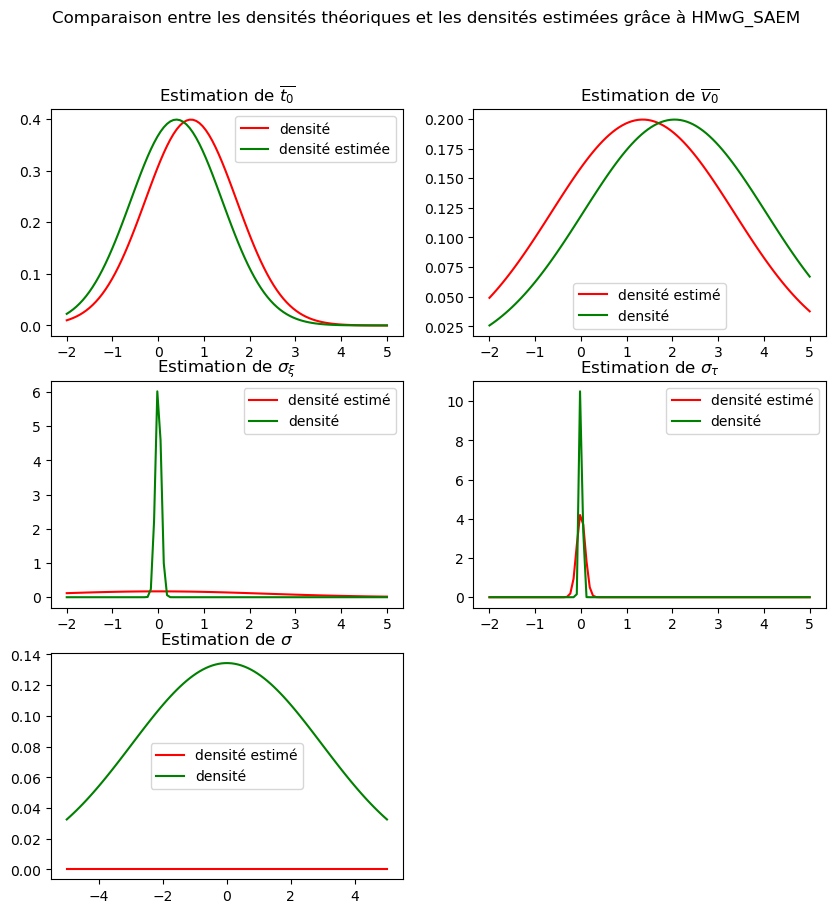

In [27]:
plt.figure(figsize = (10,10))
plt.subplot(3,2,1)
plt.plot(x,stat.norm.pdf(x,loc=t0_bar_vrai,scale=sigma_t0),color='red',label="densité")
plt.plot(x,stat.norm.pdf(x,loc=t0_bar,scale=sigma_t0),color='green',label="densité estimée")
plt.legend()
plt.title("Estimation de $\\overline{t_0}$")

plt.subplot(3,2,2)
plt.plot(x,stat.norm.pdf(x,loc=v0_bar_vrai,scale=sigma_v0),color='red',label="densité estimé")
plt.plot(x,stat.norm.pdf(x,loc=v0_bar,scale=sigma_v0),color='green',label="densité ")
plt.legend()
plt.title("Estimation de $\\overline{v_0}$")

plt.subplot(3,2,3)
plt.plot(x,stat.norm.pdf(x,loc=0,scale=sigma_xi),color='red',label="densité estimé")
plt.plot(x,stat.norm.pdf(x,loc=0,scale=sigma_xi_vrai),color='green',label="densité")
plt.legend()
plt.title("Estimation de $\\sigma_{\\xi}$")

plt.subplot(3,2,4)
plt.plot(x,stat.norm.pdf(x,loc=0,scale=sigma_tau),color='red',label="densité estimé")
plt.plot(x,stat.norm.pdf(x,loc=0,scale=sigma_tau_vrai),color='green',label="densité")
plt.legend()
plt.title("Estimation de $\\sigma_{\\tau}$")

plt.subplot(3,2,5)
x = np.linspace(-5,5,100)
plt.plot(x,stat.norm.pdf(x,loc=0,scale=sigma),color='red',label="densité estimé")
plt.plot(x,stat.norm.pdf(x,loc=0,scale=sigma_vrai),color='green',label="densité")
plt.legend()
plt.title("Estimation de $\\sigma$")

plt.suptitle("Comparaison entre les densités théoriques et les densités estimées grâce à HMwG_SAEM")

On voit que les estimations de $\overline{t_0}$, de $\overline{v_0}$ et de $\sigma_{\tau}$ sont plutôt bonnes. En revanche, et de façon assez mystérieuse, les estimations de $\sigma_{\xi}$ ainsi que de $\sigma$ sont complétement à la rue. J'ai passé beaucoup de temps à essayer de comprendre d'où venait le problème, j'imagine qu'il vient des sampleurs de MH avec Gibbs qui ne sample pas très bien les $z$. Je n'ai malheureusement pas reussi à régler les problèmes et me suis satisfait de reussir à estimer 3 paramètres sur 5 !  

### Question 9

On essaye ici d'implémenter la version par blocs de HMwG en regroupant les variables en $N+1$ blocs : $z_{pop}$ et $(z_i)_{i \in \{1,...,N\}}$. 

In [28]:
def bloc_MHwG(y,N,K,t_ij,z_init,sigma_prop,p0,t0_bar,v0_bar,sigma_xi,sigma_tau,sigma,sigma_t0,sigma_v0):
    t0_init = z_init[0]
    v0_init = z_init[1]
    xi_init = z_init[2::2]
    tau_init = z_init[3::2]
    
    #### Pour z_pop ####
    dist_current = np.zeros((N,K))
    dist_proposal = np.zeros((N,K))
    
    z_pop_proposal = stat.multivariate_normal.rvs(mean=[t0_init,v0_init],cov=sigma_prop*np.eye(2))
    t0_proposal = z_pop_proposal[0]
    v0_proposal = z_pop_proposal[1]
    
    for j in range(K) : 
        dist_current[:,j] = d(np.exp(xi_init)*(t_ij[:,j] - t0_init - tau_init) + t0_init , p0, v0_init, t0_init)

        dist_proposal[:,j]= d(np.exp(xi_init)*(t_ij[:,j] - t0_proposal - tau_init) + t0_proposal , p0, v0_proposal, t0_proposal)
    
    q_y_current = -np.sum((y - dist_current)**2)/(2*sigma**2)
    q_t0_current = -0.5*(((t0_init-t0_bar)/sigma_t0)**2)
    q_v0_current = -0.5*(((v0_init-v0_bar)/sigma_v0)**2)

    q_y_proposal = -np.sum((y - dist_proposal)**2)/(2*sigma**2)
    q_t0_proposal = -0.5*(((t0_proposal-t0_bar)/sigma_t0)**2)
    q_v0_proposal = -0.5*(((v0_proposal-v0_bar)/sigma_v0)**2)

    log_alpha_pop = min(0,q_y_proposal + q_t0_proposal + q_v0_proposal - q_y_current - q_t0_current - q_v0_current)
    U = stat.uniform.rvs()
    if np.log(U) <= log_alpha_pop:
        t0 = t0_proposal
        v0 = v0_proposal
    else:
        t0 = t0_init
        v0 = v0_init
        
    #### Pour z_i ####
    tau = np.zeros(N)
    xi = np.zeros(N)
    
    for i in range(N):
        yi = y[i, :]
                
        #Proposal 
        z_i_proposal = stat.multivariate_normal.rvs(mean=[xi_init[i],tau_init[i]],cov=sigma_prop*np.eye(2))
        #print(z_i_proposal)
        xi_i_proposal = z_i_proposal[0]
        tau_i_proposal = z_i_proposal[1]

        #Acceptance-Rejection
        q_y_current = -np.sum((yi - d(np.exp(xi_init[i])*(t_ij-t0-tau_init[i])+t0,p0,t0,v0))**2)/(2*sigma**2)
        q_xi_current = -0.5*(xi_init[i]/sigma_xi)**2
        q_tau_current = -0.5*(tau_init[i]/sigma_tau)**2
        q_y_proposal = -np.sum((yi - d(np.exp(xi_i_proposal)*(t_ij-t0-tau_i_proposal)+t0,p0,t0,v0))**2)/(2*sigma**2)
        q_xi_proposal = -0.5*(xi_i_proposal/sigma_xi)**2
        q_tau_proposal = -0.5*(tau_i_proposal/sigma_tau)**2
        
        log_alpha_i = min(0,q_y_proposal + q_tau_proposal + q_xi_proposal - q_y_current - q_tau_current - q_xi_current)
        U = stat.uniform.rvs()
        if np.log(U) <= log_alpha_i:
            tau[i] = tau_i_proposal
            xi[i] = xi_i_proposal
        else:
            tau[i] = tau_init[i]
            xi[i] = xi_init[i]

    return t0,v0,xi,tau
       

On test ensuite notre algorithme afin de verifier que les échantillons de $z$ produits sont cohérents avec le modèle théorique.

In [29]:
sigma_prop = 1e-3
nb_iter = 10000

t0 = np.zeros(nb_iter+1)
v0 = np.zeros(nb_iter+1)
tau = np.zeros((nb_iter+1,N))
xi = np.zeros((nb_iter+1,N))


t0[0] = 2*(np.random.random(1)-0.5)
v0[0] = 2*(np.random.random(1)-0.5)
tau[0] = np.random.random(N)
xi[0] = np.random.random(N)

for i in tqdm(range(nb_iter)):
    z_init = np.concatenate(([t0[i]],[v0[i]],np.insert(tau[i], np.arange(len(xi[i])), xi[i])))
    t0[i+1],v0[i+1],xi[i+1],tau[i+1] = bloc_MHwG(y,N,K,t_ij,z_init,sigma_prop,p0,t0_bar_vrai,v0_bar_vrai,
                                                 sigma_xi_vrai,sigma_tau_vrai,sigma_vrai,sigma_t0,sigma_v0)

100%|████████████████████████████████████| 10000/10000 [00:19<00:00, 510.35it/s]


Text(0.5, 1.0, "Compraison entre la densité empirique des échantillons de $v_0$ et \nla vraie densité qu'ils devraient suivre")

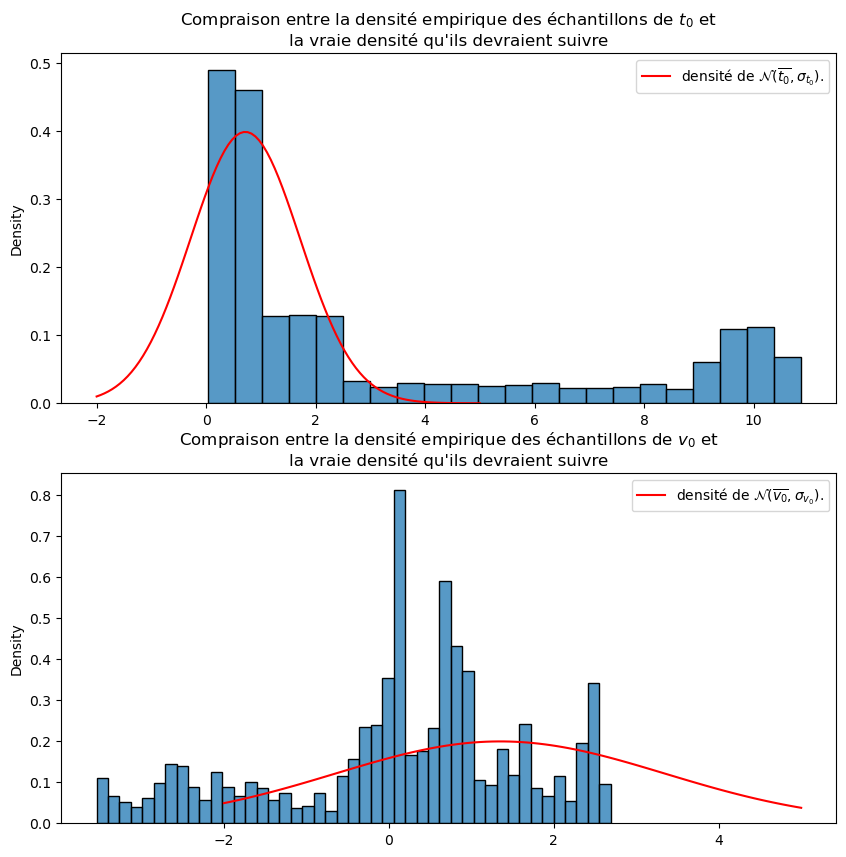

In [30]:
x = np.linspace(-2,5,100)
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
sns.histplot(t0[1000:],stat="density")
plt.plot(x,stat.norm.pdf(x,loc=t0_bar_vrai,scale=sigma_t0),color='red',label="densité de $\mathcal{N}(\overline{t_0},\sigma_{t_0})$.")
plt.legend()
plt.title("Compraison entre la densité empirique des échantillons de $t_0$ et \nla vraie densité qu\'ils devraient suivre")

plt.subplot(2,1,2)
sns.histplot(v0[1000:],stat="density")
plt.plot(x,stat.norm.pdf(x,loc=v0_bar_vrai,scale=sigma_v0),color='red',label="densité de $\mathcal{N}(\overline{v_0},\sigma_{v_0})$.")
plt.legend()
plt.title("Compraison entre la densité empirique des échantillons de $v_0$ et \nla vraie densité qu\'ils devraient suivre")

Text(0.5, 1.0, "Compraison entre la densité empirique des échantillons de $\\tau_i$ et \nla vraie densité qu'ils devraient suivre")

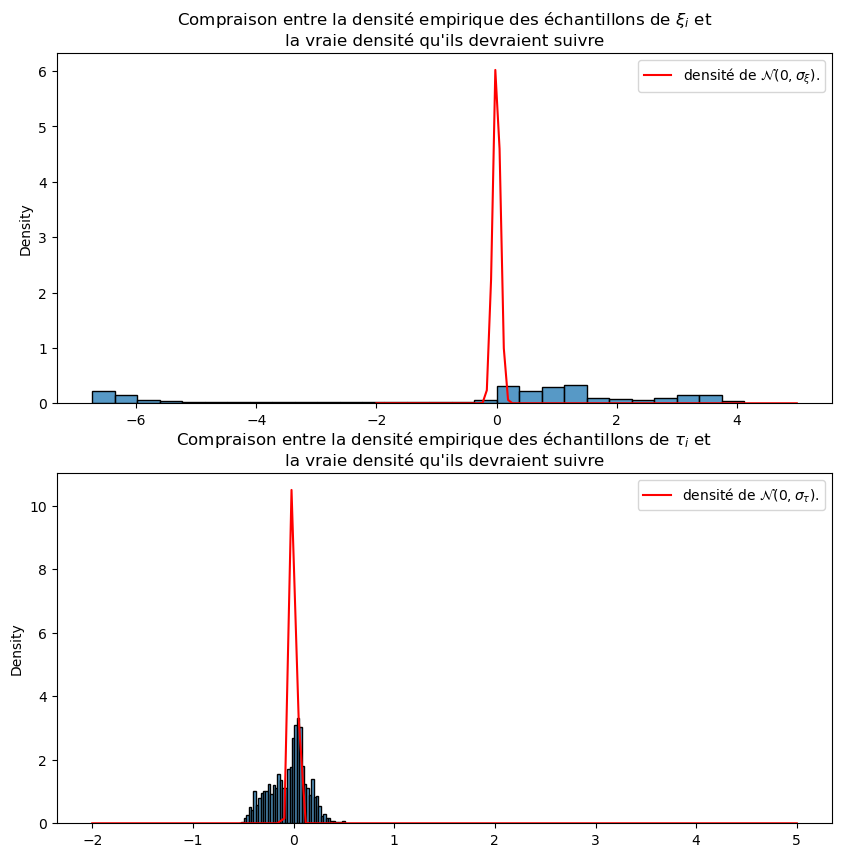

In [31]:
x = np.linspace(-2,5,100)
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
sns.histplot(xi[1000:,0],stat="density")
plt.plot(x,stat.norm.pdf(x,loc=0,scale=sigma_xi_vrai),color='red',label="densité de $\mathcal{N}(0,\sigma_{\\xi})$.")
plt.legend()
plt.title("Compraison entre la densité empirique des échantillons de $\\xi_i$ et \nla vraie densité qu\'ils devraient suivre")

plt.subplot(2,1,2)
sns.histplot(tau[1000:,0],stat="density")
plt.plot(x,stat.norm.pdf(x,loc=0,scale=sigma_tau_vrai),color='red',label="densité de $\mathcal{N}(0,\sigma_{\\tau})$.")
plt.legend()
plt.title("Compraison entre la densité empirique des échantillons de $\\tau_i$ et \nla vraie densité qu\'ils devraient suivre")


On voit que les échantillons produits sont relativement bon ! En tout cas, ils sont meilleurs que ceux produits par HMwG sans les blocs. On remarque cependant que les échantillons de $\xi_i$ ne sont pas complétement centrés en 0. Mais globalement, je suis plutôt satisfait du résultat.

Au point où j'en suis, je me dis que c'est bête de ne pas essayer d'implémenter un Block HMwG-SAEM afin d'estimer les paramètres $\theta$ du modèle grâce à l'échantillonneur par blocs ci-dessus. C'est ce que je fais donc juste en dessous.

In [32]:
def bloc_HMwG_SAEM(y,theta_init,maxIter,Nb,alpha,N,t_ij,sigma_t0, sigma_v0,sigma_prop):
    z = np.zeros((maxIter + 1,2*N+2))
    S = np.zeros((maxIter + 1,5))
    t0_bar = theta_init[0]
    v0_bar = theta_init[1]
    sigma_xi = theta_init[2]
    sigma_tau = theta_init[3]
    sigma = theta_init[4]
    nb_iter = 100
    for k in tqdm(range(maxIter)):
        #Sample of z_i and z_pop
        
        tau = np.zeros((nb_iter+1,N))
        xi = np.zeros((nb_iter+1,N))
        t0 = np.zeros(nb_iter+1)
        v0 = np.zeros(nb_iter+1)
        
        tau[0] = 2*(np.random.random(N)-1)
        xi[0] = 2*(np.random.random(N)-1)
        t0[0] = 2*(np.random.random(1)-1)
        v0[0] = 2*(np.random.random(1)-1)

        for i in range(nb_iter):
            z_init = np.concatenate(([t0[i]],[v0[i]],np.insert(tau[i], np.arange(len(xi[i])), xi[i])))
            t0[i+1],v0[i+1],xi[i+1],tau[i+1] = bloc_MHwG(y,N,K,t_ij,z_init,sigma_prop,p0,t0_bar,v0_bar,
                                                 sigma_xi,sigma_tau,sigma,sigma_t0,sigma_v0)
        
        z[k+1] = np.concatenate(([t0[-1]],[v0[-1]],np.insert(tau[-1], np.arange(len(xi[-1])), xi[-1])))
        S[k+1] = S[k] + eps(k,Nb,alpha)*(S_function(y,z[k+1]) - S[k])
        t0_bar,v0_bar,sigma_xi,sigma_tau,sigma = next_theta(S[k+1])
        
    return t0_bar,v0_bar,sigma_xi,sigma_tau,sigma

In [33]:
theta_init = np.random.random(5)
maxIter = 200
Nb = 20
a = 0.6
sigma_prop = 1e-3
(t0_bar,v0_bar,sigma_xi,sigma_tau,sigma) = bloc_HMwG_SAEM(y,theta_init,maxIter,Nb,a,N,t_ij,sigma_t0, sigma_v0,sigma_prop)

100%|█████████████████████████████████████████| 200/200 [00:37<00:00,  5.35it/s]


Text(0.5, 0.98, 'Comparaison entre les densités théoriques et les densités estimées grâce à bloc_HMwG_SAEM')

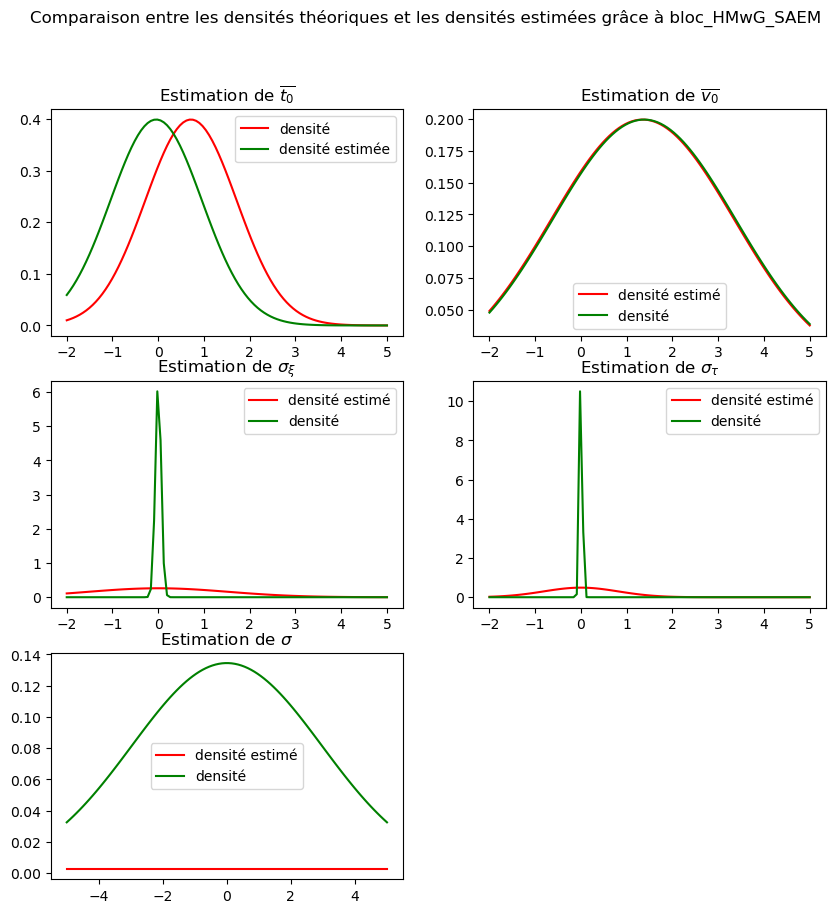

In [34]:
plt.figure(figsize = (10,10))
plt.subplot(3,2,1)
plt.plot(x,stat.norm.pdf(x,loc=t0_bar_vrai,scale=sigma_t0),color='red',label="densité")
plt.plot(x,stat.norm.pdf(x,loc=t0_bar,scale=sigma_t0),color='green',label="densité estimée")
plt.legend()
plt.title("Estimation de $\\overline{t_0}$")

plt.subplot(3,2,2)
plt.plot(x,stat.norm.pdf(x,loc=v0_bar_vrai,scale=sigma_v0),color='red',label="densité estimé")
plt.plot(x,stat.norm.pdf(x,loc=v0_bar,scale=sigma_v0),color='green',label="densité ")
plt.legend()
plt.title("Estimation de $\\overline{v_0}$")

plt.subplot(3,2,3)
plt.plot(x,stat.norm.pdf(x,loc=0,scale=sigma_xi),color='red',label="densité estimé")
plt.plot(x,stat.norm.pdf(x,loc=0,scale=sigma_xi_vrai),color='green',label="densité")
plt.legend()
plt.title("Estimation de $\\sigma_{\\xi}$")

plt.subplot(3,2,4)
plt.plot(x,stat.norm.pdf(x,loc=0,scale=sigma_tau),color='red',label="densité estimé")
plt.plot(x,stat.norm.pdf(x,loc=0,scale=sigma_tau_vrai),color='green',label="densité")
plt.legend()
plt.title("Estimation de $\\sigma_{\\tau}$")

plt.subplot(3,2,5)
x = np.linspace(-5,5,100)
plt.plot(x,stat.norm.pdf(x,loc=0,scale=sigma),color='red',label="densité estimé")
plt.plot(x,stat.norm.pdf(x,loc=0,scale=sigma_vrai),color='green',label="densité")
plt.legend()
plt.title("Estimation de $\\sigma$")

plt.suptitle("Comparaison entre les densités théoriques et les densités estimées grâce à bloc_HMwG_SAEM")

C'est avec un peu de déception que je constante que l'estimation de $\theta$ grâce à l'échantillonneur par blocs n'est pas meilleure que celle sans les blocs... Pour $\overline{t_0}$ et $\overline{v_0}$, les estimations sont bonnes, en revanche, pour $\sigma_{\xi}$,$\sigma_{\tau}$ et $\sigma$, on arrive pas du tout à estimer les bonnes valeurs.

# Exercice 2

### Question 3

#### Loi exponentielle

Pour la première distribution que l'on souhaite échantilloner, on choisit la loi exponentielle $\mathcal{E}(1)$ car elle est échantillonable par la méthode de la transformée inverse. On choisit f comme étant la distribution uniforme sur $]-1,1[$ : $\mathcal{U}(]-1,1[)$.

In [35]:
def MHM(pi,X_init,maxIter):
    #Multiplicative Hasting-Metropolis algorithm
    X = np.zeros(maxIter+1)
    X[0] = X_init
    for k in tqdm(range(maxIter)):
        eps = 2*(stat.uniform.rvs()-0.5)
        B = stat.bernoulli.rvs(p=0.5)
        if B == 1:
            Y = eps*X[k]
        else:
            Y = X[k]/eps
        
        alpha = min(1,abs(Y)/abs(X[k])*pi(Y)/pi(X[k]))
        U = stat.uniform.rvs()
        if U <= alpha:
            X[k+1] = Y
        else:
            X[k+1] = X[k]
    
    return X

In [36]:
X = MHM(stat.expon.pdf,1,100000)

100%|█████████████████████████████████| 100000/100000 [00:19<00:00, 5235.44it/s]


Text(0.5, 1.0, 'Comparaison de la densité de notre echantillon avec la vraie densité de $\\mathcal{E}(1)$')

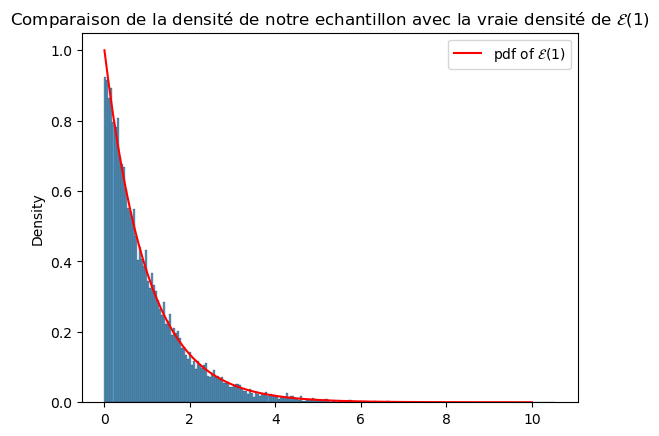

In [37]:
sns.histplot(X[1000:],stat="density")
x = np.linspace(0,10,100)
plt.plot(x,stat.expon.pdf(x),'red',label="pdf of $\mathcal{E}(1)$")
plt.legend()
plt.title("Comparaison de la densité de notre echantillon avec la vraie densité de $\mathcal{E}(1)$")

On voit que les échantillons tirés suivent bien la loi voulue $\mathcal{E}(1)$. 

On peut aussi comparer les qq-plot. C'est ce qui est fait ensuite.

((array([7.00141595e-06, 1.69948596e-05, 2.70959531e-05, ...,
         1.05161397e+01, 1.09826081e+01, 1.18694017e+01]),
  array([1.08336804e-04, 1.08336804e-04, 1.13748304e-04, ...,
         1.05504017e+01, 1.05504017e+01, 1.05504017e+01])),
 (0.9816206052668399, 0.011746712045960894, 0.9997935317340803))

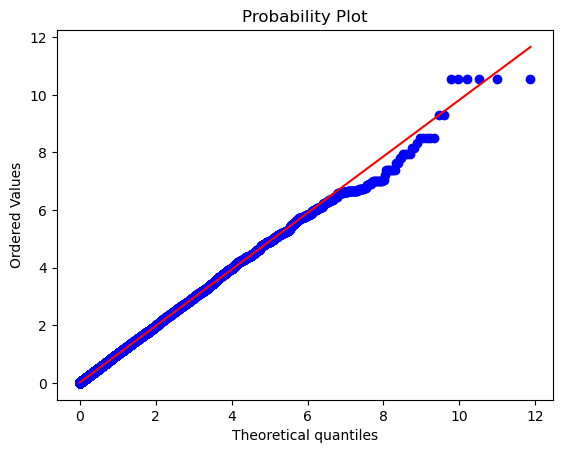

In [38]:
stat.probplot(X[1000:], dist=stat.expon, plot=plt)

On voit que nos échantillons suivent assez bien la première bissectrice, même si l'on remarque que notre méthode a tendance à donner des echantillons de valeur plus grande que ce qu'une vraie loi exponentielle donnerait. En effet, on voit que les points représentant les grandes valeurs ne sont pas parfaitement alignés avec la droite rouge. 

#### Loi normale


Pour la deuxième loi à échantillonner, on choisit une loi normale $\mathcal{N}(0,1)$.

In [39]:
X = MHM(stat.norm.pdf,1,10000)

100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4679.72it/s]


Text(0.5, 1.0, 'Comparaison de la densité de notre echantillon avec la vraie densité de $\\mathcal{N}(0,1)$')

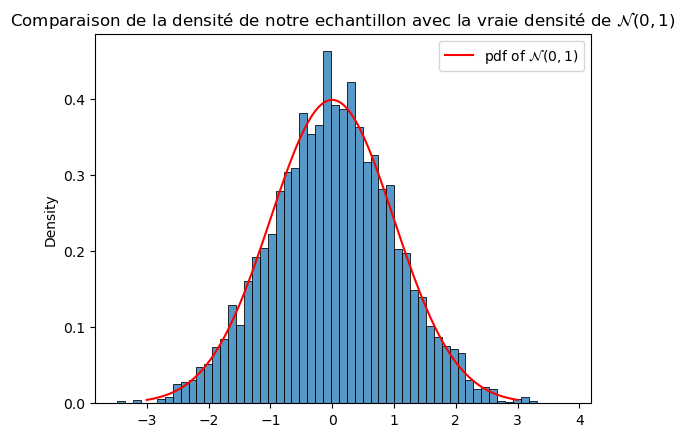

In [40]:
sns.histplot(X[1000:],stat="density")
x = np.linspace(-3,3,100)
plt.plot(x,stat.norm.pdf(x),'red',label="pdf of $\mathcal{N}(0,1)$")
plt.legend()
plt.title("Comparaison de la densité de notre echantillon avec la vraie densité de $\mathcal{N}(0,1)$")

La densité de nos echantillons ressemble assez bien à la vraie densité $\mathcal{N}(0,1)$. De plus, on voit ci-dessous sur le qq-plot que les quantiles estimés suivent très bien les quantiles empiriques de la $\mathcal{N}(0,1)$. On peut donc dire que notre méthode échantillonne très bien cette loi.

((array([-3.78451331, -3.55789956, -3.43341879, ...,  3.43341879,
          3.55789956,  3.78451331]),
  array([-3.47459388, -3.47459388, -3.42591389, ...,  3.22361556,
          3.22361556,  3.81947794])),
 (0.9982759417509399, 0.005425553446135317, 0.9998548345609073))

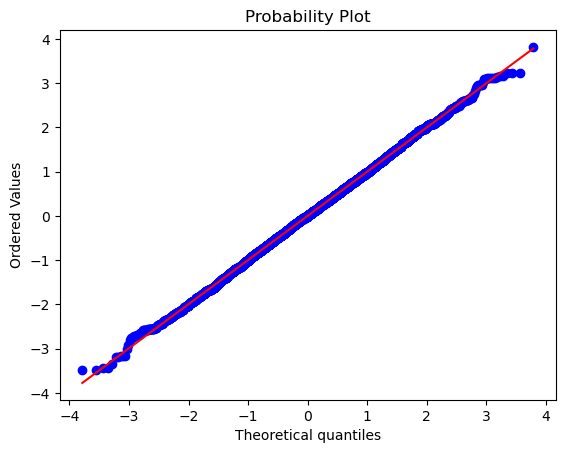

In [41]:
stat.probplot(X[1000:], plot=plt)

# Exercice 3

### Question 3

On implémente l'algorithme de Gibbs tel que décrit dans l'énoncé afin d'échantillonner la loi de $\mathbb{R} \times \mathbb{R} $ de densité $f$ donnée par 
$$\forall (x,y) \in \mathbb{R}^2,~f(x,y) = \frac{4}{\sqrt{2\pi}}y^{3/2}\text{exp}\left[-y\left(\frac{x^2}{2}+2\right)\right]\mathbb{1}_{\mathbb{R}^+}(y)$$

In [42]:
def data_augmentation(X0,Y0,maxIter):
    X = np.zeros(maxIter+1)
    Y = np.zeros(maxIter+1)
    X[0] = X0
    Y[0] = Y0
    for n in tqdm(range(maxIter)):
        X[n+1] = stat.norm.rvs(loc=0,scale=1/np.sqrt(Y[n]))
        Y[n+1] = np.random.gamma(shape=5./2.,scale=1/(2+X[n+1]**2/2))
    return X,Y


On calcul ensuite un échantillon grâce à notre algorithme et on verifie que les echantillons de $(X_n)_n$ et $(Y_n)_n$ suivent bien les lois marginales calculées théoriquement.

In [43]:
X0 = np.random.random()
Y0 = np.random.random()
maxIter = 100000
X,Y = data_augmentation(X0,Y0,maxIter)

100%|████████████████████████████████| 100000/100000 [00:02<00:00, 35244.10it/s]


In [44]:
def f_x(x):
    return 4/(np.sqrt(2*np.pi))*gamma(5./2.)/np.power(x**2/2 + 2,5./2.)

def f_y(y):
    return 4*y*np.exp(-2*y)*(y>=0)

Text(0.5, 1.0, 'Comparaison entre les tirages et la vraie marginale $f_X$')

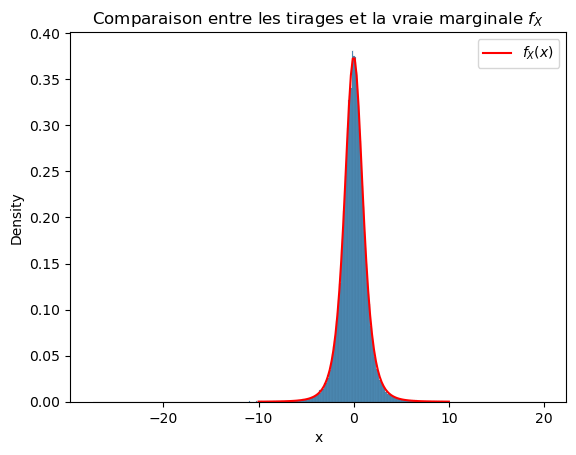

In [45]:
x = np.linspace(-10,10,100)
plt.plot(x,f_x(x),'red',label="$f_X(x)$")
plt.xlabel('x')
plt.legend()
sns.histplot(X,stat="density")
plt.title("Comparaison entre les tirages et la vraie marginale $f_X$")

Text(0.5, 1.0, 'Comparaison entre les tirages et la vraie marginale $f_Y$')

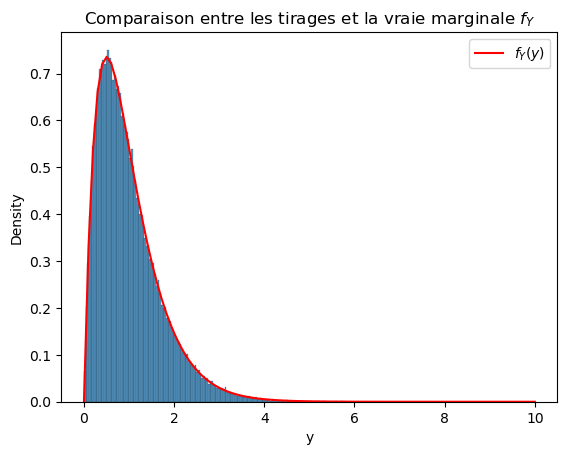

In [46]:
y = np.linspace(0,10,100)
plt.plot(y,f_y(y),'red',label="$f_Y(y)$")
plt.xlabel('y')
plt.legend()
sns.histplot(Y,stat="density")
plt.title("Comparaison entre les tirages et la vraie marginale $f_Y$")

On voit que les marginales de notre échantillon suivent bien les marginales théoriques. On est donc satisfait de notre algorithme.

### Question 4

On essaye d'estimer la quantité 
$$\int_{\mathbb{R}} \frac{H(x)}{(4 + x^2)^{5/2}} \mathrm{d} x$$
où on prend ici $H$ telle que 
$$H(x) = cos(x)$$

In [47]:
np.sqrt(2*np.pi)/(4*gamma(5./2.)*2**(5./2.))*1/maxIter*np.sum(np.cos(X))

0.04243692409975239

D'après [Wolfram Alpha](https://www.wolframalpha.com/input?i2d=true&i=Integrate%5BDivide%5Bcos%5C%2840%29x%5C%2841%29%2CPower%5B%5C%2840%294%2BPower%5Bx%2C2%5D%5C%2841%29%2C%5C%2840%29Divide%5B5%2C2%5D%5C%2841%29%5D%5D+%2C%7Bx%2C-∞%2C%2B∞%7D%5D), on obtient la bonne réponse à $10^{-4}$ près ! 